# Important Library Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Helper Functions

In [2]:
def validate_model(model, val_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in val_loader:
            batch = batch.to(device)
            labels = labels.to(device)
            
            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

def test_model(model, test_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in test_loader:
            batch = batch.to(device)
            labels = labels.to(device)
            
            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

# Set up Data Augmentation and Load Data

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize(300),
    transforms.RandomChoice([
        transforms.RandomApply([
            transforms.ElasticTransform(alpha=40.0, sigma=8.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, shear=20, fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(p=1.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomVerticalFlip(p=1.0)
        ], p=0.2),
    ]),
    transforms.CenterCrop(256),  # Crop to remove unwanted edges
    transforms.ToTensor()
])

In [41]:
LABELS = ["Apple Scab", "Apple Black Rot", "Apple Cedar Rust", "Apple Healthy", "Blueberry Healthy", "Cherry Healthy", "Cherry Powdery Mildew", "Corn Cercospora Leaf Spot", "Corn Common Rust", "Corn Healthy", "Corn Northern Leaf Blight", "Grape Black Rot", "Grape Black Measles", "Grape Healthy", "Grape Isariopsis Leaf Spot", "Orange Haunglonbing",
          "Peach Bacterial Spot", "Peach Healthy", "Bell Pepper Bacterial Spot", "Bell Pepper Healthy", "Potato Early Blight", "Potato Healthy", "Potato Late Blight", "Raspberry Healthy", "Soybean Healthy", "Squash Powdery Mildew", "Strawberry Healthy", "Strawberry Leaf Scorch", "Tomato Bacterial Spot", "Tomato Early Blight", "Tomato Healthy",
          "Tomato Late Blight", "Tomato Leaf Mold", "Tomato Septoria Leaf Spot", "Tomato Spider Mites", "Tomato Target Spot", "Tomato Mosaic Virus", "Tomato Yellow Leaf Curl Virus"]

BATCH_SIZE = 256
DEVICE = torch.device("cuda")
folder_path = "PlantVillage"

train_set = ImageFolder(root=folder_path + "\Training", transform=data_transforms)
val_set = ImageFolder(root=folder_path + "\Validation", transform=transforms.ToTensor())
test_set = ImageFolder(root=folder_path + "\Testing", transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Model Construction

In [42]:
class DiseasedCNN(nn.Module):
    def __init__(self):
        super().__init__()

        resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device=DEVICE)
        self.backbone = nn.Sequential(*list(resnet50.children())[:-2]).to(device=DEVICE) # Get everything up to the avg pooling layer
        # Freeze the base
        for param in resnet50.parameters():
            param.requires_grad = False

        conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1).to(device=DEVICE)
        relu1 = nn.ReLU().to(device=DEVICE)

        conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1).to(device=DEVICE)
        batchnorm = nn.BatchNorm2d(256).to(device=DEVICE)
        relu2 = nn.ReLU().to(device=DEVICE)
        
        pool = torch.nn.AdaptiveAvgPool2d((1,1)).to(device=DEVICE)
        flatten = torch.nn.Flatten().to(device=DEVICE)
        
        fcn1 = nn.Linear(256, 64).to(device=DEVICE)
        relu3 = nn.ReLU().to(device=DEVICE)

        fcn2 = nn.Linear(64, 38).to(device=DEVICE)
        softmax = nn.Softmax().to(DEVICE)

        self.layers = nn.Sequential(conv1, relu1, conv2, batchnorm, relu2, pool, flatten, fcn1, relu3, fcn2, softmax)

    def forward(self, x):
        x = self.backbone(x)
        return self.layers(x)

# Train Model

In [43]:
NUM_EPOCHS = 3
learning_rate = 0.0001
adam_beta1 = 0.9
adam_beta2 = 0.999

model = DiseasedCNN()

model.train() 
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2))
criterion = nn.CrossEntropyLoss()

epoch_loss = []
train_loss = []
validaction_acc = []

#Took 22 minutes to go through a single epoch. Jesus. That's 91 hours for a 250 epoch training session. 
for epoch in range(NUM_EPOCHS):
    print("Epoch: %d" % epoch)
    for step_num, (batch, labels) in enumerate(train_loader):
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)
        
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        if (step_num + 1) % 13 == 0:
            # Perform validation and store accuracy
            validation_accuracy = validate_model(model=model, val_loader=val_loader, device=DEVICE)
            validaction_acc.append(validation_accuracy)
            print(f"batch: {step_num}")

        train_loss.append(loss.item())

    # Track average loss for each epoch
    epoch_loss.append(sum(train_loss) / len(train_loss))
    print(epoch_loss[-1])

Epoch: 0
batch: 12
batch: 25
batch: 38
batch: 51
batch: 64
batch: 77
batch: 90
batch: 103
batch: 116
batch: 129
batch: 142
batch: 155
batch: 168
3.3327308710883647
Epoch: 1
batch: 12
batch: 25
batch: 38
batch: 51
batch: 64
batch: 77
batch: 90
batch: 103
batch: 116
batch: 129
batch: 142
batch: 155
batch: 168
3.240334768856273
Epoch: 2
batch: 12
batch: 25
batch: 38
batch: 51
batch: 64
batch: 77
batch: 90
batch: 103
batch: 116
batch: 129
batch: 142
batch: 155
batch: 168
3.2000188710642794


In [47]:
torch.save(model.state_dict(), "extension_model_3Epoch.pth")

### Plot Loss

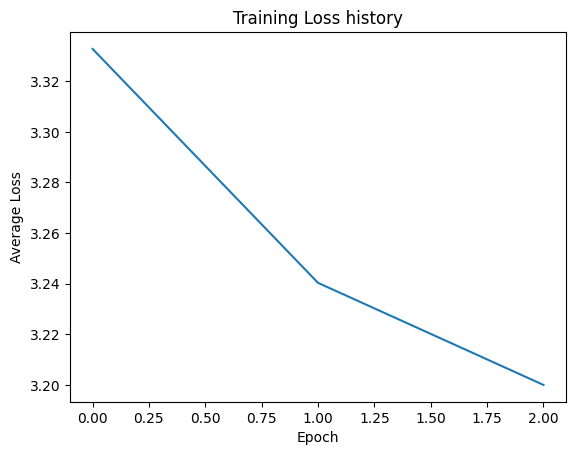

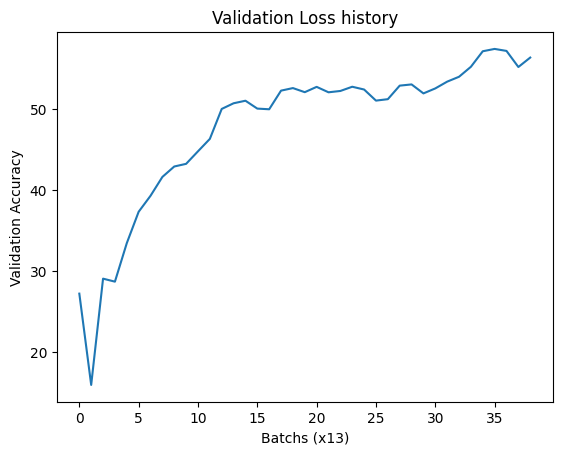

In [44]:
plt.title("Training Loss history")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.plot(epoch_loss)
plt.show()
plt.title("Validation Loss history")
plt.xlabel("Batchs (x13)")
plt.ylabel("Validation Accuracy")
plt.plot(validaction_acc)
plt.show()

### Test Model

In [45]:

accuracy = test_model(model=model, test_loader=test_loader, device=DEVICE)
print("Model accuracy: %f" % accuracy)

Model accuracy: 56.446188


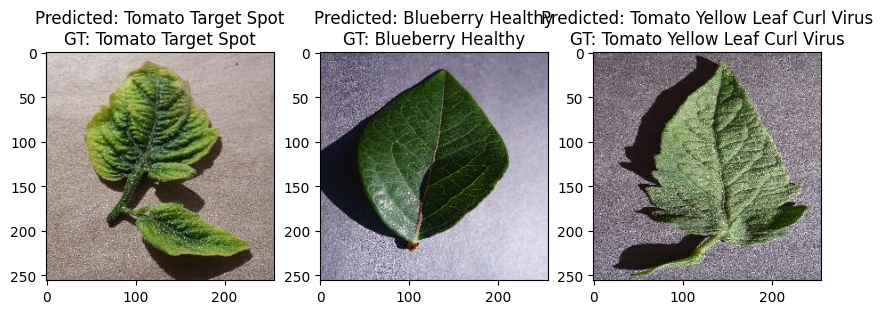

In [46]:

data = ImageFolder(root="PlantVillage\Testing", transform=transforms.Compose([transforms.ToTensor()]))

# Define data loader
dataloader = DataLoader(data, batch_size=32, shuffle=True, num_workers=4)
data_iter = iter(dataloader) 
images, labels = next(data_iter)  # Ignore labels, we only need images

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
y_pred = model(images.to(DEVICE)).argmax(dim=1)

for i in range(3):
    image = images[i].permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title("Predicted: " + LABELS[y_pred[i]] + "\nGT: " + LABELS[labels[i]])

# plt.imshow(augmented_images[0])
plt.show()